# Convolutional Neural Networks
## Image classification with CNNs
### Author: Malik Rawashdeh
### Date: 04/08/2024

### Data Loading and Exploration

Below we will load the MNIST dataset using a custom dataloader and visualize some of the images in the dataset.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install \
    --extra-index-url=https://pypi.nvidia.com \
    cudf-cu12==24.4.* dask-cudf-cu12==24.4.* cuml-cu12==24.4.* \
    cugraph-cu12==24.4.* cuspatial-cu12==24.4.* cuproj-cu12==24.4.* \
    cuxfilter-cu12==24.4.* cucim-cu12==24.4.* pylibraft-cu12==24.4.* \
    raft-dask-cu12==24.4.* cuvs-cu12==24.4.*

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 473.3/473.3 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 GB 834.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.8/137.8 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.9/920.9 kB 70.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 64.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.1/170.1 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.6/616.6 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [162]:
# import the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [163]:
# import the necessary pytorch packages
from PIL import Image
import torch

In [164]:

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [165]:
"""
This function will load the data from the nparray objects and create a DataLoader object for the training data

Parameters:
    batch_size: the size of the batch that will be used for training
    validation_size: the size of the validation set
    x_train: the training data
    y_train: the training labels
    x_test: the testing data
"""
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
def custome_dataloader(batch_size, validation_size, x_train_img, x_train_sp, y_train, x_test_img, x_test_sp):
    data_transform = transforms.Compose([
        # Flip the images randomly on the horizontal
        # Turn the image into a torch.Tensor
        transforms.Grayscale(num_output_channels=1), # convert the image to grayscale
        transforms.RandomHorizontalFlip(), # randomly flip the image horizontally
        transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
    ])
    # convert image numpy arrays to float32
    x_train_img = x_train_img.astype(np.float32)
    x_train_sp = x_train_sp.astype(np.float32)
    x_test_img = x_test_img.astype(np.float32)
    x_test_sp = x_test_sp.astype(np.float32)

    # tranform the data
    # x_train_img = data_transform(x_train_img)
    # y_train = data_transform(y_train)
    # x_test = data_transform(x_test)

    # convert the numpy arrays to PyTorch tensors and transform them
    x_train_img = torch.tensor(x_train_img).to(device)
    x_train_sp = torch.tensor(x_train_sp).to(device)
    y_train = torch.tensor(y_train).to(device)
    x_test_img = torch.tensor(x_test_img).to(device)
    x_test_sp = torch.tensor(x_test_sp).to(device)

    print("x_train_img shape: ", x_train_img.shape)
    print("x_train_sp shape: ", x_train_sp.shape)
    print("y_train shape: ", y_train.shape)
    print("x_test_img shape: ", x_test_img.shape)
    print("x_test_sp shape: ", x_test_sp.shape)





    # create a DataLoader object for the training data
    train_data_tensor = torch.utils.data.TensorDataset(x_train_img, x_train_sp, y_train)
    test_data_set = torch.utils.data.TensorDataset(x_test_img, x_test_sp)

    # split the training data into a training and validation set
    num_validation = int(validation_size * len(train_data_tensor))

    train_data_set, val_data_set = torch.utils.data.random_split(train_data_tensor, [len(train_data_tensor) - num_validation, num_validation])

    train_loader = DataLoader(dataset=train_data_set, batch_size=batch_size, shuffle=False)

    val_loader = DataLoader(dataset=val_data_set, batch_size=batch_size, shuffle=False)

    test_loader = DataLoader(dataset=test_data_set, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader



cuda


In [166]:
# load the training data from .npy files
y_train = pd.read_csv('./drive/MyDrive/sp24-tamu-csce-633-600-machine-learning/y_train.csv')
y_train = y_train.to_numpy()
y_train = y_train[:, 1]
x_test_wr = np.load('./drive/MyDrive/sp24-tamu-csce-633-600-machine-learning/x_test_wr.npy')
x_train_wr = np.load('./drive/MyDrive/sp24-tamu-csce-633-600-machine-learning/x_train_wr.npy')
x_train_sp = np.load('./drive/MyDrive/sp24-tamu-csce-633-600-machine-learning/x_train_sp.npy')
x_test_sp = np.load('./drive/MyDrive/sp24-tamu-csce-633-600-machine-learning/x_test_sp.npy')
# check the shape of the data
# check the shape of the data
print(f"The shape of the image training data is: {x_train_wr.shape}")
print(f"The shape of the spectral training data is: {x_train_sp.shape}")
print(f"The shape of the training labels is: {y_train.shape}")
print(f"The shape of the test data wr is: {x_test_wr.shape}")
print(f"The shape of the test data sp is: {x_test_sp.shape}")


The shape of the image training data is: (60000, 784)
The shape of the spectral training data is: (60000, 507)
The shape of the training labels is: (60000,)
The shape of the test data wr is: (10000, 28, 28)
The shape of the test data sp is: (10000, 507)


In [167]:
# print the data types of the data
print(f"The data type of the img training data is: {x_train_wr.dtype}")
print(f"The data type of the sp training data is: {x_train_sp.dtype}")
print(f"The data type of the training labels is: {y_train.dtype}")
print(f"The data type of the img test data is: {x_test_wr.dtype}")
print(f"The data type of the sp test data is: {x_test_sp.dtype}")

The data type of the img training data is: float64
The data type of the sp training data is: float64
The data type of the training labels is: int64
The data type of the img test data is: float64
The data type of the sp test data is: float64


### Data Shape
From the shapes of the training and testing data, we can see that the training data has 60,000 images of size 28x28 pixels, while the testing data has 10,000 images of the same size.
- The x_train array must be resized to 28x28 for each element in the array to be displayed as an image.
- The x_test array is already in the correct shape.

In [168]:
# reshape the x data
x_train_wr = x_train_wr.reshape(-1, 28, 28)

# reshape the spoken data
x_train_sp = x_train_sp.reshape(-1, 13, 39)
x_test_sp = x_test_sp.reshape(-1, 13, 39)

### Image Visualization and Digit distribution

Below we will visualize the first example of each digit (0-9) in the training data and plot the distribution of the digits in the training data.

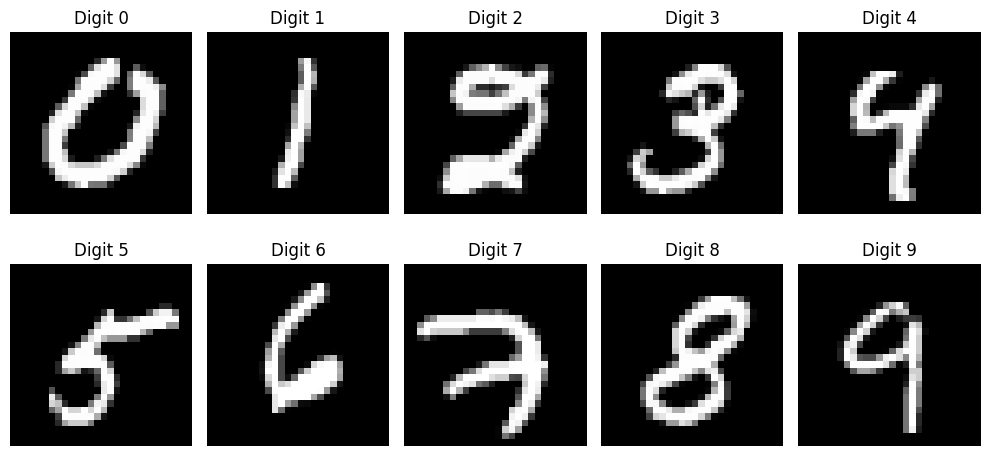

In [169]:
# Visualize one example from each digit category
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    digit_index = np.where(y_train == i)[0][0]  # Find the index of the first occurrence of digit i
    plt.imshow(x_train_wr[digit_index], cmap='gray')
    plt.title(f'Digit {i}')
    plt.axis('off')
plt.tight_layout()
plt.show()

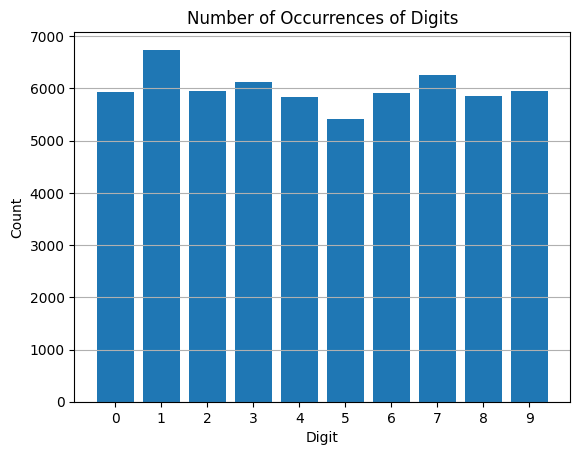

In [170]:
# show the distribution of the labels
# Assuming y_train is your target labels
unique_digits, counts = np.unique(y_train, return_counts=True)

plt.bar(unique_digits, counts)
plt.xlabel('Digit')
plt.ylabel('Count')
plt.title('Number of Occurrences of Digits')
plt.xticks(unique_digits)
plt.grid(axis='y')
plt.show()

In [171]:
digit_cnt = np.bincount(y_train)
for i in range(10):
    print(f"Digit {i} count: {digit_cnt[i]}")

# min, max and mean of the digit count
print(f"Min digit count: {np.min(digit_cnt)}")
print(f"Max digit count: {np.max(digit_cnt)}")
print(f"Mean digit count: {np.mean(digit_cnt)}")

Digit 0 count: 5923
Digit 1 count: 6742
Digit 2 count: 5958
Digit 3 count: 6131
Digit 4 count: 5842
Digit 5 count: 5421
Digit 6 count: 5918
Digit 7 count: 6265
Digit 8 count: 5851
Digit 9 count: 5949
Min digit count: 5421
Max digit count: 6742
Mean digit count: 6000.0


### Digit Count Distribution
From examining the y labels in the training data, we can see that the distribution of the digits is relatively uniform, with each digit appearing approximately 6000 times in the training data. This is important as it ensures that the model will be trained on a balanced dataset.

While the count of each digit is not exactly 6000, the distribution is close enough to be considered uniform as it averages out to 6000.

### Creating Loaders and Preprocessing
In order to train the model, we need to create data loaders for the training and testing data. We will also normalize the data by dividing by 255 to scale the pixel values to the range [0,1].

Since the images are grayscale, we will add a channel dimension to the images to make them compatible with the convolutional layers in the model.

In [172]:
# find the max pixel value in the training data to see if the data is normalized
max_pixel_value = np.max(x_train_wr)
print(f"The max pixel value in the training data is: {max_pixel_value}")
max_sp_value = np.max(x_train_sp)
print(f"The max spectral value in the training data is: {max_sp_value}")

The max pixel value in the training data is: 1.0
The max spectral value in the training data is: 1.0


Since the max value of the pixels is 1, we do not need to divide by 255.

In [173]:
# add a channel dimension to the data to make it compatible with PyTorch
x_train_wr = np.expand_dims(x_train_wr, axis=1)
x_test_wr = np.expand_dims(x_test_wr, axis=1)
x_train_sp = np.expand_dims(x_train_sp, axis=1)
x_test_sp = np.expand_dims(x_test_sp, axis=1)

# check the shape of the data
print(f"The shape of the img training data is: {x_train_wr.shape}")
print(f"The shape of the sp training data is: {x_train_sp.shape}")
print(f"The shape of the training labels is: {y_train.shape}")
print(f"The shape of the img test data is: {x_test_wr.shape}")
print(f"The shape of the sp test data is: {x_test_sp.shape}")

The shape of the img training data is: (60000, 1, 28, 28)
The shape of the sp training data is: (60000, 1, 13, 39)
The shape of the training labels is: (60000,)
The shape of the img test data is: (10000, 1, 28, 28)
The shape of the sp test data is: (10000, 1, 13, 39)


In [174]:
train_loader, validation_loader, test_loader = custome_dataloader(64, 0.2, x_train_wr, x_train_sp, y_train, x_test_wr, x_test_sp)

x_train_img shape:  torch.Size([60000, 1, 28, 28])
x_train_sp shape:  torch.Size([60000, 1, 13, 39])
y_train shape:  torch.Size([60000])
x_test_img shape:  torch.Size([10000, 1, 28, 28])
x_test_sp shape:  torch.Size([10000, 1, 13, 39])


In [175]:
# print the number of batches in the training and validation data
print(f"The number of batches in the training data is: {len(train_loader)}")
print(f"The number of batches in the validation data is: {len(validation_loader)}")
print(f"The number of batches in the test data is: {len(test_loader)}")

X_img, X_sp, y = next(iter(train_loader))
print("Training Loader example shape")
print(f"X_img shape: {X_img.shape}; y shape: {y.shape}")
print(f"X_sp shape: {X_sp.shape}")

The number of batches in the training data is: 750
The number of batches in the validation data is: 188
The number of batches in the test data is: 157
Training Loader example shape
X_img shape: torch.Size([64, 1, 28, 28]); y shape: torch.Size([64])
X_sp shape: torch.Size([64, 1, 13, 39])


Now we will check the shape of the test loader iterables which will help later. As can be seen below we will have to unpack the torch tensors when we do predictions.

In [176]:
X = next(iter(train_loader))
print(f"len(X): {len(X)}")
print(f"shape of X: {X[0].shape}")

len(X): 3
shape of X: torch.Size([64, 1, 28, 28])


In [177]:
import torch.nn as nn

### CNN Model Archetecture and Training
The CNN model consists of convolutional layers followed by max pooling layers, inputted activation functions, and fully connected layers. The model is trained using the Adam optimizer and cross-entropy loss function.

The CNN model below is adapted from the week 11 discussions on Canvas. I augmented the model from canvas by adding params for the kernel size (ie filter size), the number of layers, and the drop out rate. I also added a validation loop to tune the hyperparameters.

### Model Architecture
The model will take in a 1 channel image of size 28x28 and pass it through at least 2 convolutional layers. In similar fashion to the Discussions posted on canvas, I establish `cnn_block` and `linear_block` classes. The output of the last cnn block is passed through a fully connected layer and then to a classification layer.

The model allows tunable hyper parameters for:
- the number of convolutional layers,
- the filter/kernel size,
- stride size,
- and the dropout rate.
### NOTE: Here when I refer to the number of convolutional `layers`, I am referring to the number of cnn blocks in the model. Each cnn block consists of 2 convolutional layers, 2 batch normalizations, and 2 activation function as is explained below
Hence the number of convolutional layers is the num_cnn_layers * 2.
The number of fully connected layers is the number of linear blocks * 2 in the model since each linear block consists of 2 fully connected layers and 2 activation functions.
#### CNN Block
The CNN block consists of the following layers:
- Convolutional Layer: Applies a 2D convolution over an input signal composed of a 1 channel image of size 28x28. The convolutional layer is followed by a batch normalization layer.
- Activation Function: Applies the inputted activation function (default ReLU) to the output of the convolutional layer.
In order to ensure the same output size as the input, the padding is calculated as follows:
- padding = (kernel_size - 1) / 2
This ensures that the output size is the same as the input size.
I also added a dropout layer after the fully connected layer to prevent overfitting.
In the forward pass (ie the output of the block), I use the skip connection to add the input to the output of the convolutional layer.

#### Linear Block
The linear block consists of the following layers:
- 2 Linear Layers: Applies a linear transformation to the incoming data.
- Activation Function: Applies the inputted activation function (default ReLU) to the output of the linear layer.
- Dropout Layer: Applies dropout to the output of the linear layer to prevent overfitting.



In [178]:

class cnn_block(nn.Module):
    def __init__(self, in_channels=1, n_hidden=5, kernel_size=(2, 2), stride=1, activation_func=nn.ReLU(), dropout=0.2):
        super().__init__()
        # Calculate padding to maintain input size
        # The value of padding = (k-1)/2 since (n+2padding-k+1) = n
        # for [(n + 2padding) x (n + 2ppadding) input] * [(k x k) kernel] —> [(n x n) same input size].
        padding = ((kernel_size[0] - 1) // 2, (kernel_size[1] - 1) // 2)
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=n_hidden, kernel_size=kernel_size, bias=False, padding=padding),
            nn.BatchNorm2d(num_features=n_hidden),
            activation_func,
            nn.Dropout(p=dropout),
            nn.Conv2d(in_channels=n_hidden, out_channels=in_channels, kernel_size=kernel_size, bias=False, padding=padding),
            nn.BatchNorm2d(num_features=in_channels),
            activation_func,
            nn.Dropout(p=dropout))

    def forward(self, x):
        # residual + conv layers for skip connection
        return x + self.layers(x)

class linear_block(nn.Module):
    def __init__(self, in_features, n_hidden, activation_func=nn.ReLU(), dropout=0.2):
        super().__init__()
        self.in_features = (in_features, n_hidden)
        self.layers = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=n_hidden),
            activation_func,
            nn.Dropout(p=dropout),
            nn.Linear(in_features=n_hidden, out_features=in_features),
            activation_func,
        )

    def forward(self, x):
        return x + self.layers(x)

class CNNClassifier(nn.Module):
    def __init__(
                 self,
                 in_channels=1,
                 cnn_channels=5,
                 linear_hidden=128,
                 n_classes=10,
                 kernel_size=(3, 3),
                 stride=1,
                 cnn_layers=3,
                 activation_func=nn.ReLU(),
                 dropout_rate=0.2,
                 input_size=28*28
                ):
        super().__init__()
        self.cnn_layers = nn.Sequential(
            *[
                cnn_block(
                    in_channels,
                    cnn_channels,
                    kernel_size,
                    stride=stride,
                    activation_func=activation_func,
                    dropout=dropout_rate
                    ) for _ in range(cnn_layers)
            ])

        self.down_sample = nn.Conv2d(in_channels=in_channels, out_channels=1, kernel_size=(1, 1))

        self.linear_layers = nn.Sequential(
            linear_block(input_size, linear_hidden, activation_func=activation_func, dropout=dropout_rate),  # Adjusted input size for single-channel grayscale image
            linear_block(input_size, linear_hidden, activation_func=activation_func, dropout=dropout_rate)  # Adjusted input size for single-channel grayscale image
        )
        # Output layer
        self.last_layer = nn.Linear(input_size, n_classes)  # Adjusted input size for single-channel grayscale image

        self.all = nn.Sequential(
            self.cnn_layers,
            self.down_sample,
            nn.Flatten(),
            self.linear_layers,
            self.last_layer,
        )

    def forward(self, x):
        return self.all(x)


### Training the Model
The model is trained using the Adam optimizer and cross-entropy loss function. The model is trained for a specified number of epochs and the training and validation loss and accuracy are recorded for each epoch. The model with the best validation accuracy is selected as the final model.

Below is a function I created which will train the model and return the training and validation loss and accuracy for each epoch. The function takes in the model, training and validation data loaders, the number of epochs, and the learning rate as input parameters.

In [179]:
# Function to train the model
from torch.optim import Adam
from tqdm import tqdm
loss_func = nn.CrossEntropyLoss().to(device)
print("Training with device", device)
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-3, img=True):
    optimizer = Adam(model.parameters(), lr=learning_rate)
    avg_accuracy = 0
    for epoch in tqdm(range(num_epochs)):
        model.train()
        epoch_train_loss = []
        for images, audio, labels in train_loader:
            if img:
                X, labels = images.to(device), labels.to(device)
            else:
                X, labels = audio.to(device), labels.to(device)
            # check the dimensions of the images
            preds = model(X)

            loss = loss_func(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_loss.append(loss.item())

        # Validate the model
        model.eval()
        correct = 0
        total = 0
        epoch_val_loss = []
        with torch.no_grad():
            for images, audio, labels in val_loader:
                if img:
                    X, labels = images.to(device), labels.to(device)
                else:
                    X, labels = audio.to(device), labels.to(device)
                preds = model(X)
                loss = loss_func(preds, labels)
                epoch_val_loss.append(loss.item())
                _, predicted = torch.max(preds.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        avg_accuracy += accuracy

    return avg_accuracy / num_epochs


Training with device cuda


### Hyperparameter Tuning and Model Selection

From the previous HW 4 I used cross validation to find the best hyperparameters from the following list:
- Number of Convolutional Layers: 2, 3
- Activation Function: ReLU, Sigmoid
- Filter Size: 3, 5
- Dropout Rate: 0.2, 0.5
- Stride: 1

Below I used the best hyperparamters which scored the highest accuracy here.

In [180]:
# Define hyperparameters to search
cnn_img_model = CNNClassifier(
    in_channels=1,
    cnn_channels=5,
    linear_hidden=128,
    n_classes=10,
    kernel_size=(3, 3),
    stride=1,
    cnn_layers=3,
    activation_func=nn.ReLU(),
    dropout_rate=0.2,
    input_size=28*28
).to(device)

cnn_audio_model = CNNClassifier(
    in_channels=1,
    cnn_channels=5,
    linear_hidden=128,
    n_classes=10,
    kernel_size=(3, 3),
    stride=1,
    cnn_layers=3,
    activation_func=nn.ReLU(),
    dropout_rate=0.2,
    input_size=13*39
).to(device)

In [181]:
# train the model
accuracy = train_model(cnn_img_model, train_loader, validation_loader, num_epochs=10, learning_rate=1e-3)
print(f"\nAverage accuracy of Image CNN classifier: {accuracy}")

100%|██████████| 10/10 [00:59<00:00,  5.99s/it]


Average accuracy of Image CNN classifier: 0.974075


In [182]:
# train the model
accuracy = train_model(cnn_audio_model, train_loader, validation_loader, num_epochs=10, learning_rate=1e-3, img=False)
print(f"\nAverage accuracy for CNN audio classification: {accuracy}")

100%|██████████| 10/10 [00:57<00:00,  5.74s/it]


Average accuracy for CNN audio classification: 0.82415


## Create Encoder using the best model hyperparameters

In the previous HW, I found the best hyperparameters for the model through cross validation. Additionally, above I found that, using these hyperparameters, the model scored highly on the validation data with an accuracy of ~97% and ~82% for the image classification and audio classification tasks respectively.

Now I will use these hyperparameters and models to create an image encoder model that will be used to encode the images and audio in the MNIST dataset. Since the models scored the best validation accuracy, it is safe to say that these hyperparameters and CNN archetecture are the best for the encoder model to extract features from the images.

I can change the CNN model archetecture slightly. The model will take in an images or audio and pass it through the convolutional layer blocks which I defined above except I will remove the linear blocks and the final classification layer. The output of the last cnn block will be the encoded image. This is because the linear layers are used for classification and I am not classifying the images in this case. I am simply encoding the images to extract features from them.


In [183]:
class CNNEncoder(nn.Module):
    def __init__(
        self,
        in_channels=1,
        cnn_channels=5,
        kernel_size=(3, 3),
        stride=1,
        cnn_layers=3,
        activation_func=nn.ReLU(),
        dropout_rate=0.2
    ):
        super().__init__()
        self.cnn_layers = nn.Sequential(
            *[cnn_block(in_channels, cnn_channels, kernel_size, stride=stride, activation_func=activation_func, dropout=dropout_rate) for _ in range(cnn_layers)]
        )
        self.down_sample = nn.Conv2d(in_channels=in_channels, out_channels=1, kernel_size=(1, 1))

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.down_sample(x)
        return x

I now instantiate the model with the best hyperparameters and train it on the MNIST dataset. I will then use the model to encode the images in the MNIST dataset.

In [184]:
image_encoder = CNNEncoder(
    in_channels=1,
    cnn_channels=5,
    kernel_size=(3, 3),
    stride=1,
    cnn_layers=3,
    activation_func=nn.ReLU(),
    dropout_rate=0.2
).to(device)

audio_encoder = CNNEncoder(
    in_channels=1,
    cnn_channels=5,
    kernel_size=(3, 3),
    stride=1,
    cnn_layers=3,
    activation_func=nn.ReLU(),
    dropout_rate=0.2
).to(device)

### Training the Encoders

Since I am encoding the input data, training the encoding model will be different from training the classification model. I will use the same CNN model architecture as the classification model, but I will not use the cross-entropy loss function. Instead, I will use the mean squared error loss function to train the model to encode the images. The MSE loss function will measure the difference between the input and output images and train the model to minimize this difference.

Essentially, I am trying to train the model to encode the images in such a way that the output image is as close as possible to the input image. This will allow us to extract features from the images that can be used for classification or other tasks.

Below I define the function which will be used to train the audio and image encoders. The function takes in the model, training and validation data loaders, the number of epochs, and the learning rate as input parameters. The function will train the model using the MSE loss function and return the training and validation loss for each epoch.

In [185]:
def train_encoder(model, train_loader, num_epochs=10, learning_rate=1e-3, img=True):
    # Define the loss function and optimizer
    criterion = nn.MSELoss()  # Use Mean Squared Error loss for training the encoder
    optimizer = Adam(model.parameters(), lr=learning_rate)

    # Set the model in training mode
    model.train()
    print('Training the image encoder')
    total_loss = 0
    for epoch in tqdm(range((num_epochs))):
        for images, audio, labels in train_loader:
            if img:
                inputs = images.to(device)
            else:
                inputs = audio.to(device)

            # 0 out the parameter gradients
            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, inputs)  # Use reconstruction loss between input and output images as the loss

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

    print(f"\nTotal loss: {total_loss}")
    print(f"Average loss: {total_loss / len(train_loader)}")



    print('Finished Training')
    return model

In [186]:
# train the image encoder
image_encoder = train_encoder(image_encoder, train_loader, num_epochs=10, learning_rate=1e-3, img=True)

Training the image encoder


100%|██████████| 10/10 [00:39<00:00,  3.99s/it]


Total loss: 42.05723917850318
Average loss: 0.05607631890467091
Finished Training


In [187]:
# train the audio encoder
audio_encoder = train_encoder(audio_encoder, train_loader, num_epochs=10, learning_rate=1e-3, img=False)

Training the image encoder


100%|██████████| 10/10 [00:40<00:00,  4.10s/it]


Total loss: 12.393274820875376
Average loss: 0.016524366427833836
Finished Training


### Encoding and embedding the input data

After training the encoder models, I will use it to encode the images and audio in the training dataset. The encoded inputs will then be flattened and stitched together as input to the multimodal model Fusion model.

Below, I iterate through the training data and encode the images and audio using the trained encoder models. The encoded inputs are saved into a dataset loader in batches of 64.

In [188]:
# use the image encoder to encode the images
img_embeddings = []
audio_embeddings = []
label_arr = []
print("Shape of the train loader: ", len(train_loader))
with torch.no_grad():
    for images, audios, labels in train_loader:
        images = images.to(device)
        audios = audios.to(device)
        img_encodings = image_encoder(images)
        audio_encodings = audio_encoder(audios)
        img_embeddings.append(img_encodings)
        audio_embeddings.append(audio_encodings)
        label_arr.append(labels)

Shape of the train loader:  750


In [189]:

print("length of img embeddings: ", len(img_embeddings))
print("shape of img_embeddings: ", img_embeddings[0].shape)

print("length of audio embeddings: ", len(audio_embeddings))
print("shape of audio embeddings: ", audio_embeddings[0].shape)

img_embeddings_tensor = torch.cat(img_embeddings, dim=0).reshape(-1, 28*28)
print("shape of img_embeddings tensor: ", img_embeddings_tensor.shape)

audio_embeddings_tensor = torch.cat(audio_embeddings, dim=0).reshape(-1, 13*39)
print("shape of audio_embeddings tensor: ", audio_embeddings_tensor.shape)


print(f"shape of labels array {len(label_arr)}")
label_arr = torch.cat(label_arr, dim=0)
print(f"shape of labels array {label_arr.shape}")

labels = label_arr.cpu()

length of img embeddings:  750
shape of img_embeddings:  torch.Size([64, 1, 28, 28])
length of audio embeddings:  750
shape of audio embeddings:  torch.Size([64, 1, 13, 39])
shape of img_embeddings tensor:  torch.Size([48000, 784])
shape of audio_embeddings tensor:  torch.Size([48000, 507])
shape of labels array 750
shape of labels array torch.Size([48000])


## Dimensiality Reduction and Feature Extraction with t-SNE

After encoding the input data, I will use t-SNE to reduce the dimensionality of the encoded data and extract features from the images and audio. t-SNE is a dimensionality reduction technique. It works by modeling the high-dimensional data in a lower-dimensional space while preserving the local structure of the data.

To demonstrate this, I plot the t-SNE embeddings of the encoded images and audio in a 2D space with color coded labels. The t-SNE embeddings will allow us to visualize the features extracted from the images and audio and see how they are distributed in the lower-dimensional space.

I use the `cuml.manifold` library instead of the scikit-learn library since it is significantly faster by utilizing parallel computing

In [190]:
from cuml.manifold import TSNE

In [191]:
# Apply t-SNE for dimensionality reduction
tsne_img = TSNE(n_components=2)

img_embeddings_2d = tsne_img.fit_transform(img_embeddings_tensor.to('cpu').numpy())
print("Done transforming Images...")

tsne_audio = TSNE(n_components=2)

audio_embeddings_2d = tsne_audio.fit_transform(img_embeddings_tensor.to('cpu').numpy())
print("Done transforming Images...")


[W] [00:01:22.155536] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Done transforming Images...
[W] [00:01:27.809757] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
Done transforming Images...


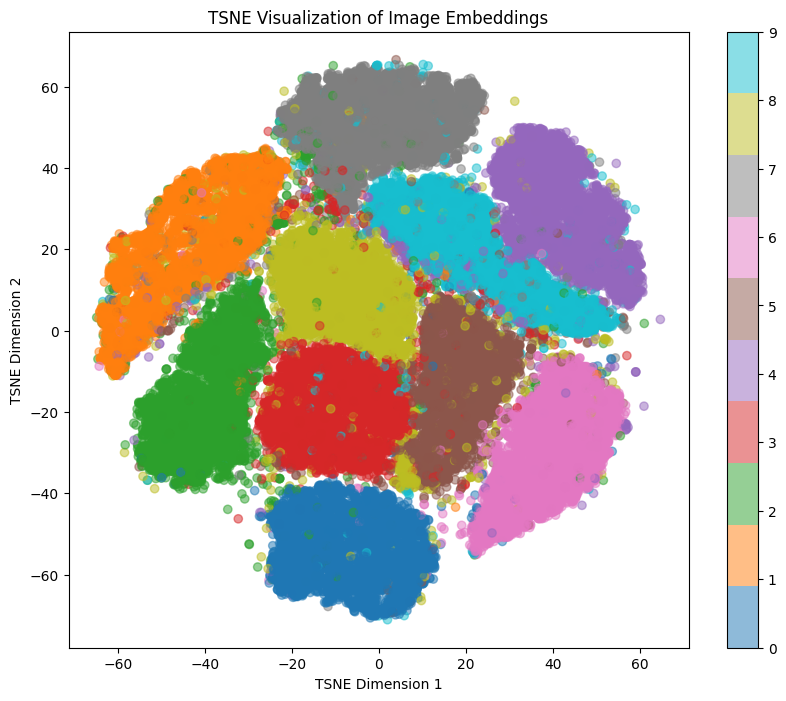

In [192]:
# Visualize embeddings

plt.figure(figsize=(10, 8))
plt.scatter(img_embeddings_2d[:, 0], img_embeddings_2d[:, 1], alpha=0.5, c=labels, cmap='tab10')
plt.title('TSNE Visualization of Image Embeddings')
plt.xlabel('TSNE Dimension 1')
plt.ylabel('TSNE Dimension 2')
plt.colorbar()
plt.show()

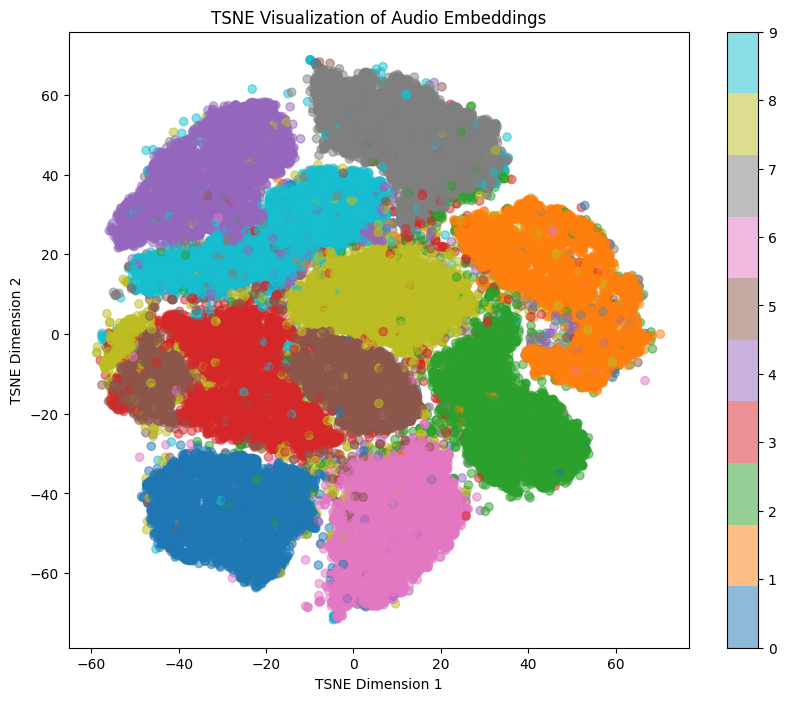

In [193]:
plt.figure(figsize=(10, 8))
plt.scatter(audio_embeddings_2d[:, 0], audio_embeddings_2d[:, 1], alpha=0.5, c=labels, cmap='tab10')
plt.title('TSNE Visualization of Audio Embeddings')
plt.xlabel('TSNE Dimension 1')
plt.ylabel('TSNE Dimension 2')
plt.colorbar()
plt.show()

As can be seen above, encoding the images and embedding them in 2D space through t-SNE creates for a nice visual clustering of the input data. The data clusters together for each class and the model is able to extract features from the images and audio that allow it to differentiate between the different classes.


## K-Means Clustering
Since the t-SNE embeddings show that the encoded data is clustered together based on the class labels, I will use K-Means clustering to cluster the encoded data into 10 clusters. K-Means clustering is an unsupervised learning algorithm that partitions the data into K clusters based on the similarity of the data points. This means we do not use the labels in the clustering process.

In [194]:
from sklearn.cluster import KMeans

In [195]:
# Perform k-means clustering on the 2D image embeddings
kmeans_img = KMeans(n_clusters=10, random_state=42)
clusters_img = kmeans_img.fit_predict(img_embeddings_2d)

# Perform k-means clustering on the 2D audio embeddings
kmeans_audio = KMeans(n_clusters=10, random_state=42)
clusters_audio = kmeans_audio.fit_predict(audio_embeddings_2d)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


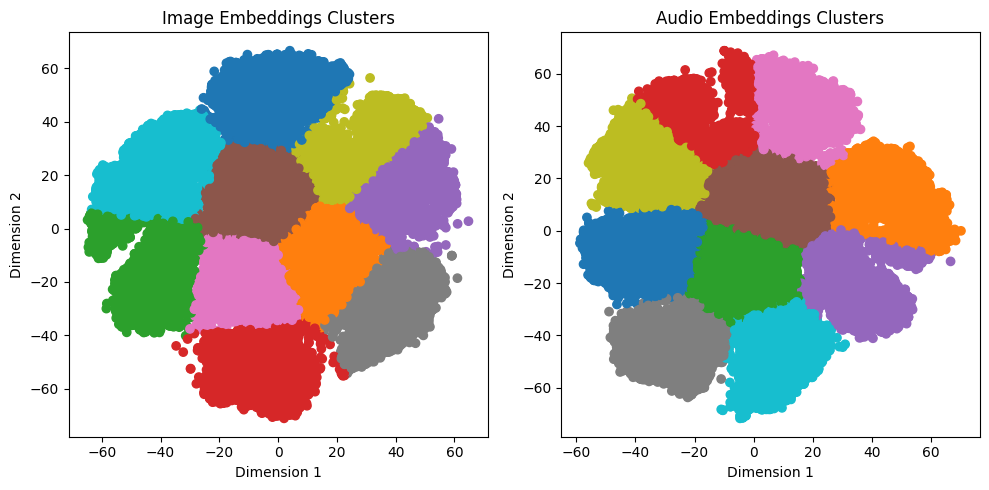

In [196]:
# Visualize clusters for image embeddings
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(img_embeddings_2d[:, 0], img_embeddings_2d[:, 1], c=clusters_img, cmap='tab10')
plt.title('Image Embeddings Clusters')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Visualize clusters for audio embeddings
plt.subplot(1, 2, 2)
plt.scatter(audio_embeddings_2d[:, 0], audio_embeddings_2d[:, 1], c=clusters_audio, cmap='tab10')
plt.title('Audio Embeddings Clusters')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.tight_layout()
plt.show()

## Fusion Model


In [197]:
def make_embedding_dataloader(x_wr_tensor, x_sp_tensor, y_tensor, batch_size=64, validation_size=0.1):
    data_tensor = torch.utils.data.TensorDataset(x_wr_tensor, x_sp_tensor, y_tensor)
    num_validation = int(validation_size * len(data_tensor))
    train_data_set, val_data_set = torch.utils.data.random_split(data_tensor, [len(data_tensor) - num_validation, num_validation])
    train_loader = DataLoader(dataset=train_data_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_data_set, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader


In [198]:

embeddings_train_loader, embeddings_val_loader = make_embedding_dataloader(img_embeddings_tensor, audio_embeddings_tensor, label_arr)
print(f"Length of the embeddings train loader: {len(embeddings_train_loader)}")
print(f"Length of the embeddings validation loader: {len(embeddings_val_loader)}")
print(f"Shape of the img embeddings train loader: {next(iter(embeddings_train_loader))[0].shape}")
print(f"Shape of the audio embeddings train loader: {next(iter(embeddings_train_loader))[1].shape}")
print(f"Shape of the labels embeddings train loader: {next(iter(embeddings_train_loader))[2].shape}")
print(f"Shape of the img embeddings validation loader: {next(iter(embeddings_val_loader))[0].shape}")
print(f"Shape of the audio embeddings validation loader: {next(iter(embeddings_val_loader))[1].shape}")
print(f"Shape of the labels embeddings validation loader: {next(iter(embeddings_val_loader))[2].shape}")

Length of the embeddings train loader: 675
Length of the embeddings validation loader: 75
Shape of the img embeddings train loader: torch.Size([64, 784])
Shape of the audio embeddings train loader: torch.Size([64, 507])
Shape of the labels embeddings train loader: torch.Size([64])
Shape of the img embeddings validation loader: torch.Size([64, 784])
Shape of the audio embeddings validation loader: torch.Size([64, 507])
Shape of the labels embeddings validation loader: torch.Size([64])


## Fusion Model Architecture and Training
Below, I define the Fusion model which will take in the encoded images and audio as input and pass them through 2 fully connected linear layers with a ReLU activation function. I could have added another layer to the model, however 2 layers is suffecient for this task as I am using the second layer as the classification layer. This is the same linear layer archetecture I included in the CNN Classifier above which is why I am confident that this model will perform well.

The output of the model are probabilities for each class which are used to classify the input data. The max probability is selected as the predicted class label.

In [199]:
class FusionModel(nn.Module):
    def __init__(self, image_encoding_size, audio_encoding_size, hidden_size, num_classes):
        super(FusionModel, self).__init__()
        self.fc1 = nn.Linear(image_encoding_size + audio_encoding_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, image_encoding, audio_encoding):
        # NOTE: images and audios are already flattened
        # Concatenate image and audio encodings
        fused_encoding = torch.cat((image_encoding, audio_encoding), dim=1)

        # Pass the fused encoding through the network
        out = self.fc1(fused_encoding)
        out = self.relu(out)  # Use the defined ReLU layer
        out = self.fc2(out)
        return out

In [200]:
# define the model
fusion_model = FusionModel(
    image_encoding_size=28*28,
    audio_encoding_size=507,
    hidden_size=128,
    num_classes=10
).to(device)

Now I train the model with cross-entropy loss function and Adam optimizer. The model is trained for 10 epochs and the training and validation loss and accuracy are recorded for each epoch. The model accuracy is displayed at the end.

In [201]:
# train the model with new data
optimizer = Adam(fusion_model.parameters(), lr=1e-3)
avg_accuracy = 0
loss_func = nn.CrossEntropyLoss().to(device)

for epoch in tqdm(range(10)):
    fusion_model.train()
    epoch_train_loss = []
    for image_encodings, audio_encodings, labels in embeddings_train_loader:
        image_encodings = image_encodings.to(device)
        audio_encodings = audio_encodings.to(device)
        labels = labels.to(device)

        # Get the embedding

        # Forward pass
        preds = fusion_model(image_encodings, audio_encodings)
        loss = loss_func(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss.append(loss.item())

    # Validate the model
    fusion_model.eval()
    correct = 0
    total = 0
    epoch_val_loss = []
    with torch.no_grad():
        for image_encodings, audio_encodings, labels in embeddings_val_loader:
            image_encodings = image_encodings.to(device)
            audio_encodings = audio_encodings.to(device)
            labels = labels.to(device)

            preds = fusion_model(image_encodings, audio_encodings)
            loss = loss_func(preds, labels)
            epoch_val_loss.append(loss.item())
            _, predicted = torch.max(preds.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    avg_accuracy += accuracy
print(f"\nAverage accuracy for the fusion model: {avg_accuracy / 10}")



100%|██████████| 10/10 [00:19<00:00,  1.92s/it]


Average accuracy for the fusion model: 0.9537291666666665



Below we encode the images



In [202]:
# use the image encoder and audio encoder to encode the test data
img_embeddings_test = []
audio_embeddings_test = []

with torch.no_grad():
    for images, audios in test_loader:
        images = images.to(device)
        audios = audios.to(device)
        img_encodings = image_encoder(images)
        audio_encodings = audio_encoder(audios)
        img_embeddings_test.append(img_encodings)
        audio_embeddings_test.append(audio_encodings)

In [203]:

print("length of img embeddings: ", len(img_embeddings_test))
print("shape of img_embeddings_test: ", img_embeddings_test[0].shape)

print("length of audio embeddings: ", len(audio_embeddings_test))
print("shape of audio embeddings: ", audio_embeddings_test[0].shape)

img_embeddings_test_tensor = torch.cat(img_embeddings_test, dim=0).reshape(-1, 28*28)
print("shape of img_embeddings_test tensor: ", img_embeddings_test_tensor.shape)

audio_embeddings_test_tensor = torch.cat(audio_embeddings_test, dim=0).reshape(-1, 13*39)
print("shape of audio_embeddings_test tensor: ", audio_embeddings_test_tensor.shape)


length of img embeddings:  157
shape of img_embeddings_test:  torch.Size([64, 1, 28, 28])
length of audio embeddings:  157
shape of audio embeddings:  torch.Size([64, 1, 13, 39])
shape of img_embeddings_test tensor:  torch.Size([10000, 784])
shape of audio_embeddings_test tensor:  torch.Size([10000, 507])


In [204]:
# make the test data loader
data_test_tensor = torch.utils.data.TensorDataset(img_embeddings_test_tensor, audio_embeddings_test_tensor)
test_loader = DataLoader(dataset=data_test_tensor, batch_size=64, shuffle=False)


In [205]:
predictions = []

with torch.no_grad():
    for image_encodings, audio_encodings in test_loader:
        image_encodings = image_encodings.to(device)
        audio_encodings = audio_encodings.to(device)

        preds = fusion_model(image_encodings, audio_encodings)
        _, predicted = torch.max(preds.data, 1)
        predictions.extend(predicted.cpu().numpy())
predictions = np.array(predictions)

In [206]:
# save the predictions to a csv file
preds_df = pd.DataFrame(predictions, columns=['label'])
# add row_id column
preds_df['row_id'] = preds_df.index
file_name = 'Malik_Rawashdeh_Preds.csv'
preds_df.to_csv(file_name, index=False)
print("Predictions saved to", file_name)

Predictions saved to Malik_Rawashdeh_Preds.csv


## Appendix: Model Hyperparameter tuning

Below I show the process I used to find the best model hyperparameters.



In [207]:
train_loader_orig, validation_loader_orig, test_loader_orig = custome_dataloader(64, 0.2, x_train_wr, x_train_sp, y_train, x_test_wr, x_test_sp)

x_train_img shape:  torch.Size([60000, 1, 28, 28])
x_train_sp shape:  torch.Size([60000, 1, 13, 39])
y_train shape:  torch.Size([60000])
x_test_img shape:  torch.Size([10000, 1, 28, 28])
x_test_sp shape:  torch.Size([10000, 1, 13, 39])


In [208]:
# Define hyperparameters to search
num_layers_list = [2, 3]
activation_list = [nn.ReLU(), nn.Sigmoid()]
dropout_list = [0.2, 0.5]
kernel_sizes = [(3, 3), (5, 5)]
strides = [1]
models = {
}
sorted_models = []

# Perform hyperparameter search
best_accuracy = 0
best_hyperparameters = None


for num_layers in num_layers_list:
    for activation in activation_list:
        for dropout in dropout_list:
            for filter_size in kernel_sizes:
                for stride in strides:
                    model = CNNClassifier(
                        in_channels=1,
                        cnn_channels=5,
                        linear_hidden=128,
                        n_classes=10,
                        kernel_size=filter_size,
                        stride=stride,
                        cnn_layers=num_layers,
                        activation_func=activation,
                        dropout_rate=dropout,
                        input_size=28*28
                        ).to(device)
                    print(f"Training Image model with hyperparameters: (num_layers={num_layers}, activation={activation}, dropout={dropout}, kernel_size={filter_size}, stride={stride})")
                    cur_accuracy = train_model(model, train_loader_orig, validation_loader_orig, num_epochs=10, learning_rate=1e-3)
                    if cur_accuracy > best_accuracy:
                        best_accuracy = cur_accuracy
                        best_hyperparameters = {'num_layers': num_layers, 'activation': activation, 'dropout': dropout, 'kernel_size': filter_size, 'stride': stride}
                    print(f'Accuracy: {cur_accuracy:.4f}, Hyperparameters: (num_layers={num_layers}, activation={activation}, dropout={dropout}, kernel_size={filter_size}, stride={stride})')
                    print()
                    models[(num_layers, activation, dropout, filter_size)] = model
                    sorted_models.append((cur_accuracy, (num_layers, activation, dropout, filter_size, stride)))


print('Best Image hyperparameters:', best_hyperparameters)
print('Best validation accuracy:', best_accuracy)

Training Image model with hyperparameters: (num_layers=2, activation=ReLU(), dropout=0.2, kernel_size=(3, 3), stride=1)


100%|██████████| 10/10 [00:48<00:00,  4.82s/it]


Accuracy: 0.9703, Hyperparameters: (num_layers=2, activation=ReLU(), dropout=0.2, kernel_size=(3, 3), stride=1)

Training Image model with hyperparameters: (num_layers=2, activation=ReLU(), dropout=0.2, kernel_size=(5, 5), stride=1)


100%|██████████| 10/10 [00:47<00:00,  4.77s/it]


Accuracy: 0.9776, Hyperparameters: (num_layers=2, activation=ReLU(), dropout=0.2, kernel_size=(5, 5), stride=1)

Training Image model with hyperparameters: (num_layers=2, activation=ReLU(), dropout=0.5, kernel_size=(3, 3), stride=1)


100%|██████████| 10/10 [00:49<00:00,  4.94s/it]


Accuracy: 0.9680, Hyperparameters: (num_layers=2, activation=ReLU(), dropout=0.5, kernel_size=(3, 3), stride=1)

Training Image model with hyperparameters: (num_layers=2, activation=ReLU(), dropout=0.5, kernel_size=(5, 5), stride=1)


100%|██████████| 10/10 [00:48<00:00,  4.82s/it]


Accuracy: 0.9486, Hyperparameters: (num_layers=2, activation=ReLU(), dropout=0.5, kernel_size=(5, 5), stride=1)

Training Image model with hyperparameters: (num_layers=2, activation=Sigmoid(), dropout=0.2, kernel_size=(3, 3), stride=1)


100%|██████████| 10/10 [00:47<00:00,  4.73s/it]


Accuracy: 0.9614, Hyperparameters: (num_layers=2, activation=Sigmoid(), dropout=0.2, kernel_size=(3, 3), stride=1)

Training Image model with hyperparameters: (num_layers=2, activation=Sigmoid(), dropout=0.2, kernel_size=(5, 5), stride=1)


100%|██████████| 10/10 [00:48<00:00,  4.90s/it]


Accuracy: 0.9652, Hyperparameters: (num_layers=2, activation=Sigmoid(), dropout=0.2, kernel_size=(5, 5), stride=1)

Training Image model with hyperparameters: (num_layers=2, activation=Sigmoid(), dropout=0.5, kernel_size=(3, 3), stride=1)


100%|██████████| 10/10 [00:46<00:00,  4.63s/it]


Accuracy: 0.9384, Hyperparameters: (num_layers=2, activation=Sigmoid(), dropout=0.5, kernel_size=(3, 3), stride=1)

Training Image model with hyperparameters: (num_layers=2, activation=Sigmoid(), dropout=0.5, kernel_size=(5, 5), stride=1)


100%|██████████| 10/10 [00:47<00:00,  4.74s/it]


Accuracy: 0.9599, Hyperparameters: (num_layers=2, activation=Sigmoid(), dropout=0.5, kernel_size=(5, 5), stride=1)

Training Image model with hyperparameters: (num_layers=3, activation=ReLU(), dropout=0.2, kernel_size=(3, 3), stride=1)


100%|██████████| 10/10 [00:56<00:00,  5.61s/it]


Accuracy: 0.9752, Hyperparameters: (num_layers=3, activation=ReLU(), dropout=0.2, kernel_size=(3, 3), stride=1)

Training Image model with hyperparameters: (num_layers=3, activation=ReLU(), dropout=0.2, kernel_size=(5, 5), stride=1)


100%|██████████| 10/10 [00:55<00:00,  5.52s/it]


Accuracy: 0.9773, Hyperparameters: (num_layers=3, activation=ReLU(), dropout=0.2, kernel_size=(5, 5), stride=1)

Training Image model with hyperparameters: (num_layers=3, activation=ReLU(), dropout=0.5, kernel_size=(3, 3), stride=1)


100%|██████████| 10/10 [00:54<00:00,  5.50s/it]


Accuracy: 0.9691, Hyperparameters: (num_layers=3, activation=ReLU(), dropout=0.5, kernel_size=(3, 3), stride=1)

Training Image model with hyperparameters: (num_layers=3, activation=ReLU(), dropout=0.5, kernel_size=(5, 5), stride=1)


100%|██████████| 10/10 [00:53<00:00,  5.40s/it]


Accuracy: 0.9689, Hyperparameters: (num_layers=3, activation=ReLU(), dropout=0.5, kernel_size=(5, 5), stride=1)

Training Image model with hyperparameters: (num_layers=3, activation=Sigmoid(), dropout=0.2, kernel_size=(3, 3), stride=1)


100%|██████████| 10/10 [00:53<00:00,  5.37s/it]


Accuracy: 0.9608, Hyperparameters: (num_layers=3, activation=Sigmoid(), dropout=0.2, kernel_size=(3, 3), stride=1)

Training Image model with hyperparameters: (num_layers=3, activation=Sigmoid(), dropout=0.2, kernel_size=(5, 5), stride=1)


100%|██████████| 10/10 [00:53<00:00,  5.31s/it]


Accuracy: 0.9690, Hyperparameters: (num_layers=3, activation=Sigmoid(), dropout=0.2, kernel_size=(5, 5), stride=1)

Training Image model with hyperparameters: (num_layers=3, activation=Sigmoid(), dropout=0.5, kernel_size=(3, 3), stride=1)


100%|██████████| 10/10 [00:53<00:00,  5.36s/it]


Accuracy: 0.9492, Hyperparameters: (num_layers=3, activation=Sigmoid(), dropout=0.5, kernel_size=(3, 3), stride=1)

Training Image model with hyperparameters: (num_layers=3, activation=Sigmoid(), dropout=0.5, kernel_size=(5, 5), stride=1)


100%|██████████| 10/10 [00:52<00:00,  5.26s/it]

Accuracy: 0.9491, Hyperparameters: (num_layers=3, activation=Sigmoid(), dropout=0.5, kernel_size=(5, 5), stride=1)

Best Image hyperparameters: {'num_layers': 2, 'activation': ReLU(), 'dropout': 0.2, 'kernel_size': (5, 5), 'stride': 1}
Best validation accuracy: 0.9775916666666667


In [209]:
# Define hyperparameters to search
num_layers_list = [2, 3]
activation_list = [nn.ReLU(), nn.Sigmoid()]
dropout_list = [0.2, 0.5]
kernel_sizes = [(3, 3), (5, 5)]
strides = [1]
models = {
}
sorted_models = []

# Perform hyperparameter search
best_accuracy = 0
best_hyperparameters = None


for num_layers in num_layers_list:
    for activation in activation_list:
        for dropout in dropout_list:
            for filter_size in kernel_sizes:
                for stride in strides:
                    model = CNNClassifier(
                        in_channels=1,
                        cnn_channels=5,
                        linear_hidden=128,
                        n_classes=10,
                        kernel_size=filter_size,
                        stride=stride,
                        cnn_layers=num_layers,
                        activation_func=activation,
                        dropout_rate=dropout,
                        input_size=507
                        ).to(device)
                    print(f"Training Audio model with hyperparameters: (num_layers={num_layers}, activation={activation}, dropout={dropout}, kernel_size={filter_size}, stride={stride})")
                    cur_accuracy = train_model(model, train_loader_orig, validation_loader_orig, num_epochs=10, learning_rate=1e-3, img=False)
                    if cur_accuracy > best_accuracy:
                        best_accuracy = cur_accuracy
                        best_hyperparameters = {'num_layers': num_layers, 'activation': activation, 'dropout': dropout, 'kernel_size': filter_size, 'stride': stride}
                    print(f'Accuracy: {cur_accuracy:.4f}, Hyperparameters: (num_layers={num_layers}, activation={activation}, dropout={dropout}, kernel_size={filter_size}, stride={stride})')
                    print()
                    models[(num_layers, activation, dropout, filter_size)] = model
                    sorted_models.append((cur_accuracy, (num_layers, activation, dropout, filter_size, stride)))


print('Best Audio hyperparameters:', best_hyperparameters)
print('Best validation accuracy:', best_accuracy)

Training Audio model with hyperparameters: (num_layers=2, activation=ReLU(), dropout=0.2, kernel_size=(3, 3), stride=1)


100%|██████████| 10/10 [00:48<00:00,  4.80s/it]


Accuracy: 0.8612, Hyperparameters: (num_layers=2, activation=ReLU(), dropout=0.2, kernel_size=(3, 3), stride=1)

Training Audio model with hyperparameters: (num_layers=2, activation=ReLU(), dropout=0.2, kernel_size=(5, 5), stride=1)


100%|██████████| 10/10 [00:46<00:00,  4.67s/it]


Accuracy: 0.8574, Hyperparameters: (num_layers=2, activation=ReLU(), dropout=0.2, kernel_size=(5, 5), stride=1)

Training Audio model with hyperparameters: (num_layers=2, activation=ReLU(), dropout=0.5, kernel_size=(3, 3), stride=1)


100%|██████████| 10/10 [00:47<00:00,  4.75s/it]


Accuracy: 0.8003, Hyperparameters: (num_layers=2, activation=ReLU(), dropout=0.5, kernel_size=(3, 3), stride=1)

Training Audio model with hyperparameters: (num_layers=2, activation=ReLU(), dropout=0.5, kernel_size=(5, 5), stride=1)


100%|██████████| 10/10 [00:48<00:00,  4.86s/it]


Accuracy: 0.7260, Hyperparameters: (num_layers=2, activation=ReLU(), dropout=0.5, kernel_size=(5, 5), stride=1)

Training Audio model with hyperparameters: (num_layers=2, activation=Sigmoid(), dropout=0.2, kernel_size=(3, 3), stride=1)


100%|██████████| 10/10 [00:45<00:00,  4.56s/it]


Accuracy: 0.7688, Hyperparameters: (num_layers=2, activation=Sigmoid(), dropout=0.2, kernel_size=(3, 3), stride=1)

Training Audio model with hyperparameters: (num_layers=2, activation=Sigmoid(), dropout=0.2, kernel_size=(5, 5), stride=1)


100%|██████████| 10/10 [00:46<00:00,  4.66s/it]


Accuracy: 0.7953, Hyperparameters: (num_layers=2, activation=Sigmoid(), dropout=0.2, kernel_size=(5, 5), stride=1)

Training Audio model with hyperparameters: (num_layers=2, activation=Sigmoid(), dropout=0.5, kernel_size=(3, 3), stride=1)


100%|██████████| 10/10 [00:46<00:00,  4.62s/it]


Accuracy: 0.7012, Hyperparameters: (num_layers=2, activation=Sigmoid(), dropout=0.5, kernel_size=(3, 3), stride=1)

Training Audio model with hyperparameters: (num_layers=2, activation=Sigmoid(), dropout=0.5, kernel_size=(5, 5), stride=1)


100%|██████████| 10/10 [00:46<00:00,  4.68s/it]


Accuracy: 0.6497, Hyperparameters: (num_layers=2, activation=Sigmoid(), dropout=0.5, kernel_size=(5, 5), stride=1)

Training Audio model with hyperparameters: (num_layers=3, activation=ReLU(), dropout=0.2, kernel_size=(3, 3), stride=1)


100%|██████████| 10/10 [00:54<00:00,  5.43s/it]


Accuracy: 0.8535, Hyperparameters: (num_layers=3, activation=ReLU(), dropout=0.2, kernel_size=(3, 3), stride=1)

Training Audio model with hyperparameters: (num_layers=3, activation=ReLU(), dropout=0.2, kernel_size=(5, 5), stride=1)


100%|██████████| 10/10 [00:54<00:00,  5.49s/it]


Accuracy: 0.8970, Hyperparameters: (num_layers=3, activation=ReLU(), dropout=0.2, kernel_size=(5, 5), stride=1)

Training Audio model with hyperparameters: (num_layers=3, activation=ReLU(), dropout=0.5, kernel_size=(3, 3), stride=1)


100%|██████████| 10/10 [00:54<00:00,  5.42s/it]


Accuracy: 0.8204, Hyperparameters: (num_layers=3, activation=ReLU(), dropout=0.5, kernel_size=(3, 3), stride=1)

Training Audio model with hyperparameters: (num_layers=3, activation=ReLU(), dropout=0.5, kernel_size=(5, 5), stride=1)


100%|██████████| 10/10 [00:54<00:00,  5.45s/it]


Accuracy: 0.7080, Hyperparameters: (num_layers=3, activation=ReLU(), dropout=0.5, kernel_size=(5, 5), stride=1)

Training Audio model with hyperparameters: (num_layers=3, activation=Sigmoid(), dropout=0.2, kernel_size=(3, 3), stride=1)


100%|██████████| 10/10 [00:53<00:00,  5.37s/it]


Accuracy: 0.7729, Hyperparameters: (num_layers=3, activation=Sigmoid(), dropout=0.2, kernel_size=(3, 3), stride=1)

Training Audio model with hyperparameters: (num_layers=3, activation=Sigmoid(), dropout=0.2, kernel_size=(5, 5), stride=1)


100%|██████████| 10/10 [00:52<00:00,  5.26s/it]


Accuracy: 0.7381, Hyperparameters: (num_layers=3, activation=Sigmoid(), dropout=0.2, kernel_size=(5, 5), stride=1)

Training Audio model with hyperparameters: (num_layers=3, activation=Sigmoid(), dropout=0.5, kernel_size=(3, 3), stride=1)


100%|██████████| 10/10 [00:52<00:00,  5.27s/it]


Accuracy: 0.7104, Hyperparameters: (num_layers=3, activation=Sigmoid(), dropout=0.5, kernel_size=(3, 3), stride=1)

Training Audio model with hyperparameters: (num_layers=3, activation=Sigmoid(), dropout=0.5, kernel_size=(5, 5), stride=1)


100%|██████████| 10/10 [00:53<00:00,  5.31s/it]

Accuracy: 0.6955, Hyperparameters: (num_layers=3, activation=Sigmoid(), dropout=0.5, kernel_size=(5, 5), stride=1)

Best Audio hyperparameters: {'num_layers': 3, 'activation': ReLU(), 'dropout': 0.2, 'kernel_size': (5, 5), 'stride': 1}
Best validation accuracy: 0.8970083333333333
